In [2]:
%load_ext autoreload
%autoreload 2

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from theano.ifelse import ifelse
from theano import tensor as T, function, printing
import theano
theano.config.compute_test_value='ignore'
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"


from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series

from models.seir.seir_testing import SEIR_Testing, SEIR_Test_pymc3
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle, train_val_split
from main.seir.forecast import create_region_csv, create_all_csvs, write_csv, plot_forecast

## Comparison of E/Hosp and I/Hosp ratios

In [4]:
for district in predictions_dict.keys():
    district_dict = predictions_dict[district]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['E'] / district_dict['m1']['df_prediction']['hospitalised'],
            '-', color='C0', label='E / Hosp (M1)')
    ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['I'] / district_dict['m1']['df_prediction']['hospitalised'],
            '-.', color='C0', label='I / Hosp (M1)')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People')
    plt.xlabel('Time')
    plt.legend()
    plt.title('I/Hosp and E/Hosp ratio for {}, {}'.format(district[0], district[1]))
    plt.grid()
    plt.show()

NameError: name 'predictions_dict' is not defined

## Load Covid19india Data

In [8]:
dataframes = get_covid19india_api_data()

In [9]:
predictions_dict = {}

## Select Districts to fit on

In [10]:
districts_to_show = [('Maharashtra', 'Pune'), 
                     ('Maharashtra', 'Mumbai'), 
                     ('Rajasthan', 'Jaipur'), 
                     ('Gujarat', 'Ahmedabad'), 
                     ('Karnataka', 'Bengaluru Urban'),
                     ('Delhi', None)]

## Perform M1 and M2 fits

fitting to data with "train_on_val" set to False ..


/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
16  Maharashtra     Pune 2020-05-12        1745.0          2976.0     163.2   
17  Maharashtra     Pune 2020-05-13        1770.8          3136.4     168.4   
18  Maharashtra     Pune 2020-05-14        1863.2          3308.0     174.4   
19  Maharashtra     Pune 2020-05-15        1963.8          3484.8     181.0   
20  Maharashtra     Pune 2020-05-16        2035.0          3666.8     189.2   

    recovered  
16     1067.8  
17     1197.2  
18     1270.4  
19     1340.0  
20     1442.6  
val
          state district       date hospitalised total_infected deceased  \
0  Maharashtra     Pune 2020-05-17       2084.6         3818.2    195.2   
1  Maharashtra     Pune 2020-05-18       2188.8         4017.4    204.2   
2  Maharashtra     Pune 2020-05-19       2298.8           4221    213.4   
3  Maharashtra     Pune 2020-05-20       2438.2         4455.4    222.6   
4  Mah

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date hospitalised total_infected deceased  \
23  Maharashtra     Pune 2020-05-19       2298.8           4221    213.4   
24  Maharashtra     Pune 2020-05-20       2438.2         4455.4    222.6   
25  Maharashtra     Pune 2020-05-21       2583.4         4710.6      233   
26  Maharashtra     Pune 2020-05-22         2810           4993      243   
27  Maharashtra     Pune 2020-05-23         2916           5347      257   

   recovered  
23    1708.8  
24    1794.6  
25    1894.2  
26      1940  
27      2174  
val
 None
100%|██████████| 1500/1500 [02:19<00:00, 10.74trial/s, best loss: 0.6852246298764008]
best parameters
 {'E_hosp_ratio': 0.9214818209417341, 'I_hosp_ratio': 0.45447831066119593, 'P_fatal': 0.25180261324369474, 'P_severe': 0.3527379824380044, 'R0': 3.7689558410168735, 'T_inc': 4.916339914036042, 'T_inf': 3.4844708105997797, 'T_recov_severe': 13.267908356979085, 'intervention_amount': 0.4815085008307

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
16  Maharashtra   Mumbai 2020-05-12       12185.0         15138.4     553.8   
17  Maharashtra   Mumbai 2020-05-13       12726.6         15924.8     583.2   
18  Maharashtra   Mumbai 2020-05-14       13321.0         16731.6     616.8   
19  Maharashtra   Mumbai 2020-05-15       14129.0         17772.2     652.4   
20  Maharashtra   Mumbai 2020-05-16       14963.0         18889.8     692.6   

    recovered  
16     2399.6  
17     2615.0  
18     2793.8  
19     2990.8  
20     3234.2  
val
          state district       date hospitalised total_infected deceased  \
0  Maharashtra   Mumbai 2020-05-17        15657        19809.2    719.8   
1  Maharashtra   Mumbai 2020-05-18      16627.6        21098.6      757   
2  Maharashtra   Mumbai 2020-05-19        17691        22487.6    794.2   
3  Maharashtra   Mumbai 2020-05-20        18622        23907.8    829.2   
4  Mah

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date hospitalised total_infected deceased  \
23  Maharashtra   Mumbai 2020-05-19        17691        22487.6    794.2   
24  Maharashtra   Mumbai 2020-05-20        18622        23907.8    829.2   
25  Maharashtra   Mumbai 2020-05-21      19606.8        25404.2    867.6   
26  Maharashtra   Mumbai 2020-05-22        20573          27251      909   
27  Maharashtra   Mumbai 2020-05-23        21772          28817      949   

   recovered  
23    4002.4  
24    4456.6  
25    4929.8  
26      5769  
27      6096  
val
 None
100%|██████████| 1500/1500 [02:11<00:00, 11.39trial/s, best loss: 2.134178105886087] 
best parameters
 {'E_hosp_ratio': 0.6483566556378656, 'I_hosp_ratio': 0.2578751803391829, 'P_fatal': 0.2536172515771765, 'P_severe': 0.7433470466109305, 'R0': 4.786466789371316, 'T_inc': 4.854204485858531, 'T_inf': 3.0541048687285617, 'T_recov_severe': 19.19300076391478, 'intervention_amount': 0.17945643212030898

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
         state district       date  hospitalised  total_infected  deceased  \
16  Rajasthan   Jaipur 2020-05-12         415.8          1290.2      60.2   
17  Rajasthan   Jaipur 2020-05-13         426.2          1323.4      61.4   
18  Rajasthan   Jaipur 2020-05-14         457.4          1377.2      62.4   
19  Rajasthan   Jaipur 2020-05-15         497.2          1436.2      63.6   
20  Rajasthan   Jaipur 2020-05-16         521.6          1492.4      64.8   

    recovered  
16      814.2  
17      835.8  
18      857.4  
19      875.4  
20      906.0  
val
        state district       date hospitalised total_infected deceased  \
0  Rajasthan   Jaipur 2020-05-17        549.2           1548     66.2   
1  Rajasthan   Jaipur 2020-05-18        572.4           1604     68.2   
2  Rajasthan   Jaipur 2020-05-19          572           1638     70.4   
3  Rajasthan   Jaipur 2020-05-20          560         1665.8     72.2   
4  Rajasthan   Jaipur 2020-0

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
         state district       date hospitalised total_infected deceased  \
23  Rajasthan   Jaipur 2020-05-19          572           1638     70.4   
24  Rajasthan   Jaipur 2020-05-20          560         1665.8     72.2   
25  Rajasthan   Jaipur 2020-05-21        542.8         1688.6       74   
26  Rajasthan   Jaipur 2020-05-22          534           1715       75   
27  Rajasthan   Jaipur 2020-05-23          486           1737       77   

   recovered  
23     995.6  
24    1033.6  
25    1071.8  
26      1106  
27      1174  
val
 None
100%|██████████| 1500/1500 [02:55<00:00,  8.53trial/s, best loss: 3.670793739302458] 
best parameters
 {'E_hosp_ratio': 0.03300223962905255, 'I_hosp_ratio': 0.7266605486754574, 'P_fatal': 0.0005472273539392069, 'P_severe': 0.3011232216019597, 'R0': 4.441647692546704, 'T_inc': 4.419360658220944, 'T_inf': 3.44024008218861, 'T_recov_severe': 10.880633974341553, 'intervention_amount': 0.01882184686656661}
fitting

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
       state   district       date  hospitalised  total_infected  deceased  \
16  Gujarat  Ahmedabad 2020-05-12        4122.2          6362.4     422.6   
17  Gujarat  Ahmedabad 2020-05-13        4171.4          6633.0     442.2   
18  Gujarat  Ahmedabad 2020-05-14        4351.8          7044.6     460.8   
19  Gujarat  Ahmedabad 2020-05-15        4587.4          7458.0     481.4   
20  Gujarat  Ahmedabad 2020-05-16        4827.4          7865.6     503.2   

    recovered  
16     1817.6  
17     2019.4  
18     2232.0  
19     2389.2  
20     2535.0  
val
      state   district       date hospitalised total_infected deceased  \
0  Gujarat  Ahmedabad 2020-05-17         5057         8272.6    525.4   
1  Gujarat  Ahmedabad 2020-05-18       5291.8         8681.6      550   
2  Gujarat  Ahmedabad 2020-05-19       5370.6         8942.6    575.2   
3  Gujarat  Ahmedabad 2020-05-20       5407.6         9203.4    599.4   
4  Gujarat  Ahmedabad 2020-0

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
       state   district       date hospitalised total_infected deceased  \
23  Gujarat  Ahmedabad 2020-05-19       5370.6         8942.6    575.2   
24  Gujarat  Ahmedabad 2020-05-20       5407.6         9203.4    599.4   
25  Gujarat  Ahmedabad 2020-05-21       5443.8           9467    622.2   
26  Gujarat  Ahmedabad 2020-05-22         5421           9724      645   
27  Gujarat  Ahmedabad 2020-05-23         5468          10001      669   

   recovered  
23    2996.8  
24    3196.4  
25      3401  
26      3658  
27      3864  
val
 None
100%|██████████| 1500/1500 [02:45<00:00,  9.05trial/s, best loss: 0.5640040333110713]
best parameters
 {'E_hosp_ratio': 0.0009444288509397904, 'I_hosp_ratio': 0.37964074117061797, 'P_fatal': 0.10991308326773874, 'P_severe': 0.6224095465718115, 'R0': 2.5545150870265747, 'T_inc': 4.5284548483750156, 'T_inf': 3.4144250088390318, 'T_recov_severe': 17.187012011135074, 'intervention_amount': 0.44596497970375487}
fi

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
         state         district       date  hospitalised  total_infected  \
16  Karnataka  Bengaluru Urban 2020-05-12          82.0           182.0   
17  Karnataka  Bengaluru Urban 2020-05-13          84.2           187.0   
18  Karnataka  Bengaluru Urban 2020-05-14          87.2           194.6   
19  Karnataka  Bengaluru Urban 2020-05-15          88.0           201.4   
20  Karnataka  Bengaluru Urban 2020-05-16          94.0           212.6   

    deceased  recovered  
16       7.0       92.0  
17       7.0       95.0  
18       7.0       99.8  
19       7.0      106.0  
20       7.0      111.4  
val
        state         district       date hospitalised total_infected deceased  \
0  Karnataka  Bengaluru Urban 2020-05-17        100.2            224      7.2   
1  Karnataka  Bengaluru Urban 2020-05-18        104.8          233.6      7.6   
2  Karnataka  Bengaluru Urban 2020-05-19          111            242        8   
3  Karnataka  Bengalu

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
         state         district       date hospitalised total_infected  \
23  Karnataka  Bengaluru Urban 2020-05-19          111            242   
24  Karnataka  Bengaluru Urban 2020-05-20        118.4          251.4   
25  Karnataka  Bengaluru Urban 2020-05-21        121.6          256.8   
26  Karnataka  Bengaluru Urban 2020-05-22          124            263   
27  Karnataka  Bengaluru Urban 2020-05-23          127            267   

   deceased recovered  
23        8       123  
24      8.4     124.6  
25        9     126.2  
26        9       130  
27       10       130  
val
 None
100%|██████████| 1500/1500 [02:15<00:00, 11.06trial/s, best loss: 1.6200216075886966]
best parameters
 {'E_hosp_ratio': 0.2895928755351823, 'I_hosp_ratio': 0.4852620062496519, 'P_fatal': 0.2999226958119199, 'P_severe': 0.6076828131392763, 'R0': 3.086815219021837, 'T_inc': 4.633252242029408, 'T_inf': 3.8076425372770375, 'T_recov_severe': 19.969983314212424, 'inte

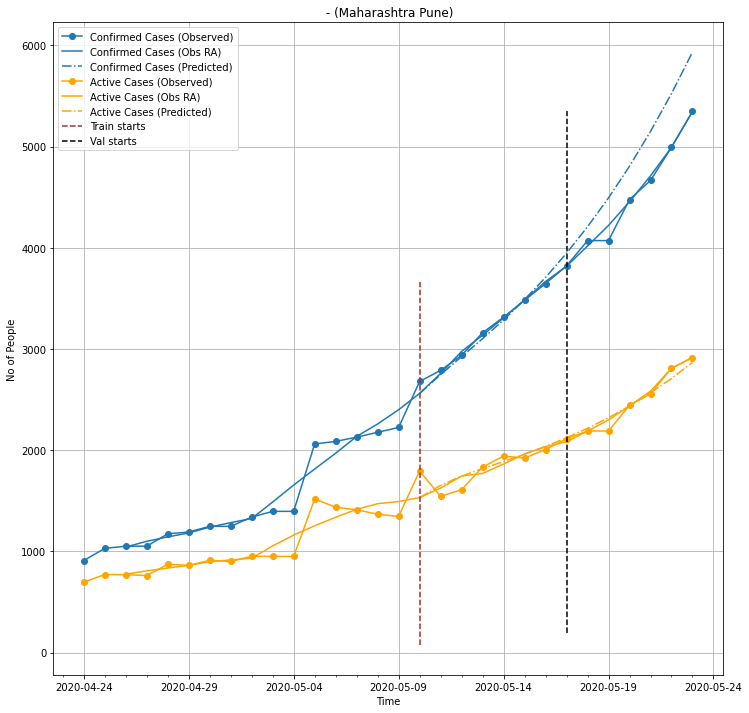

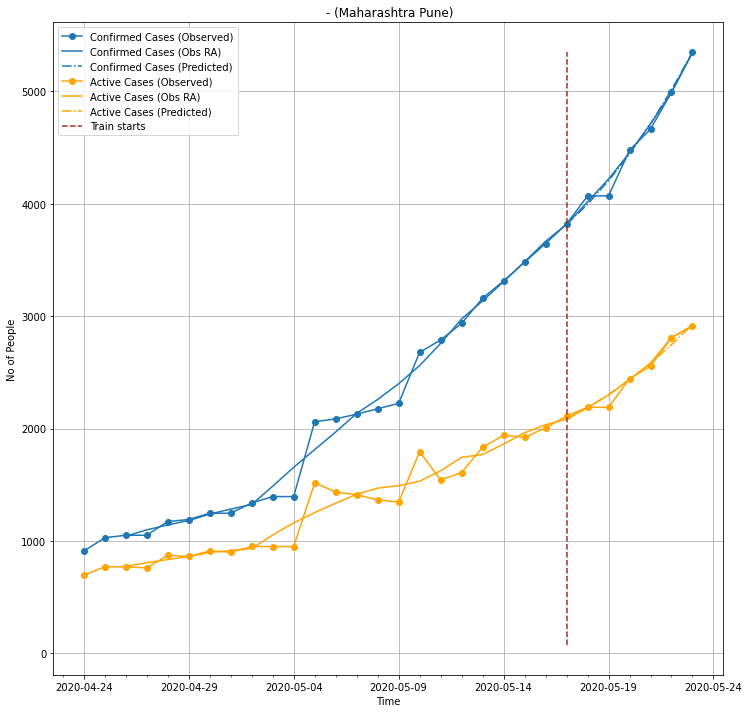

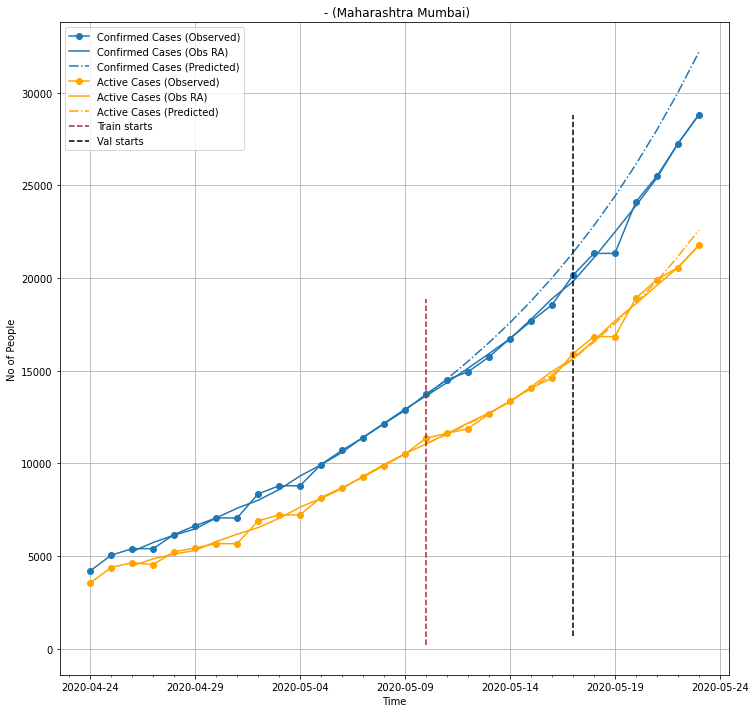

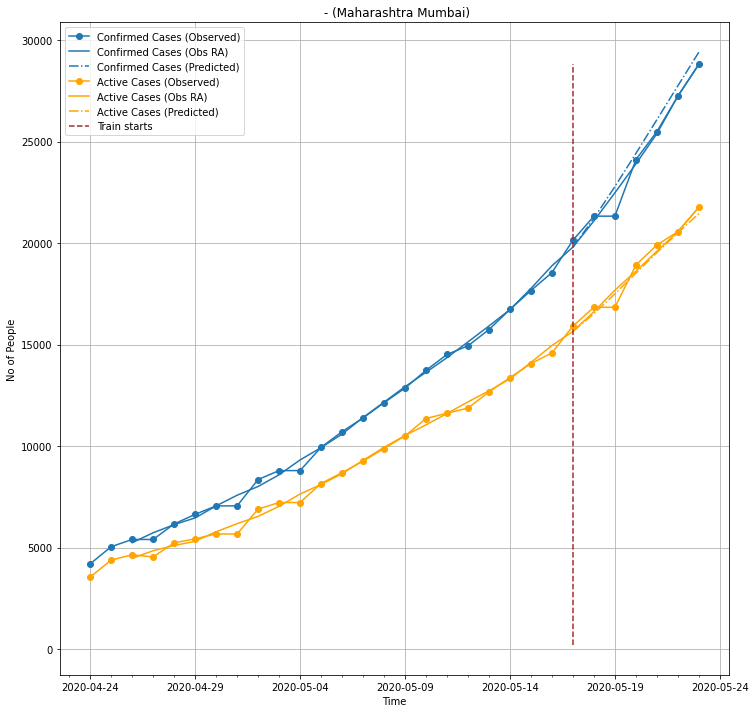

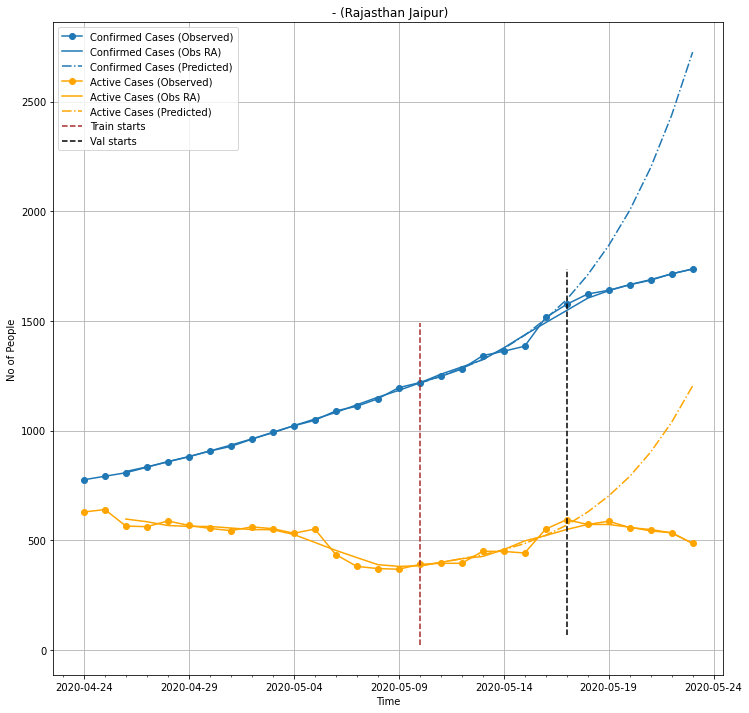

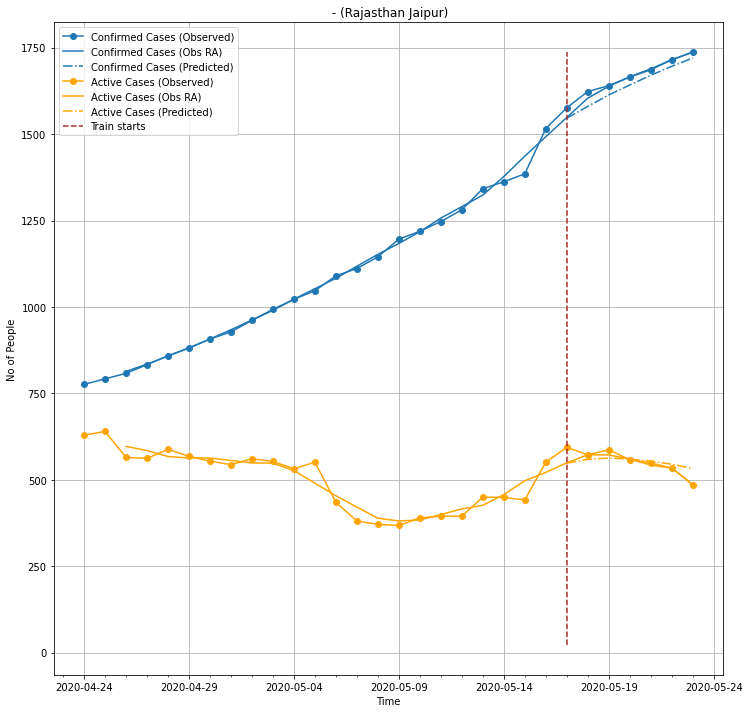

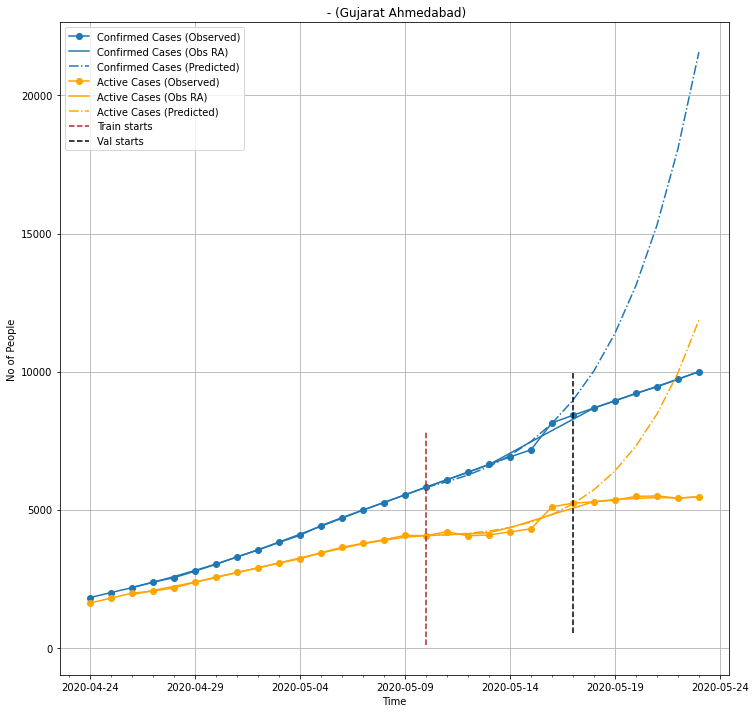

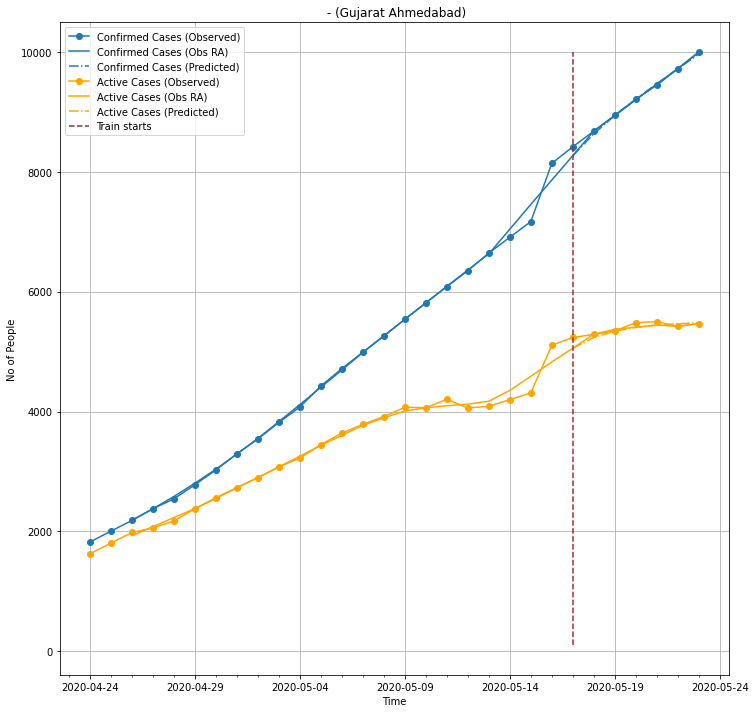

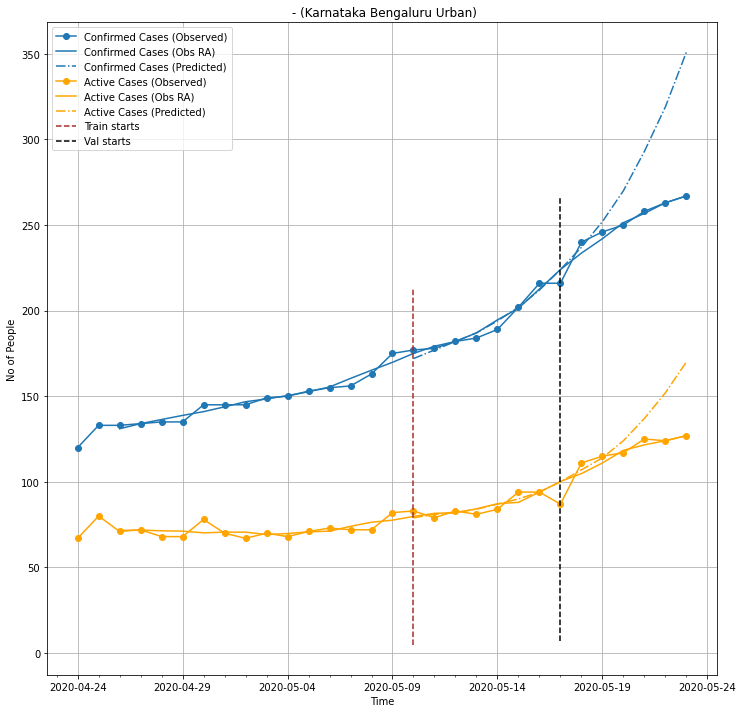

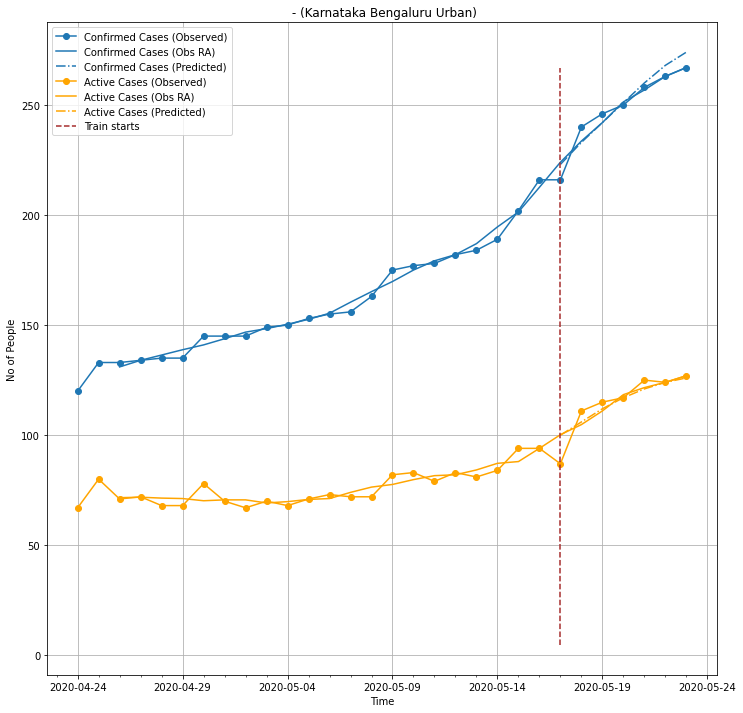

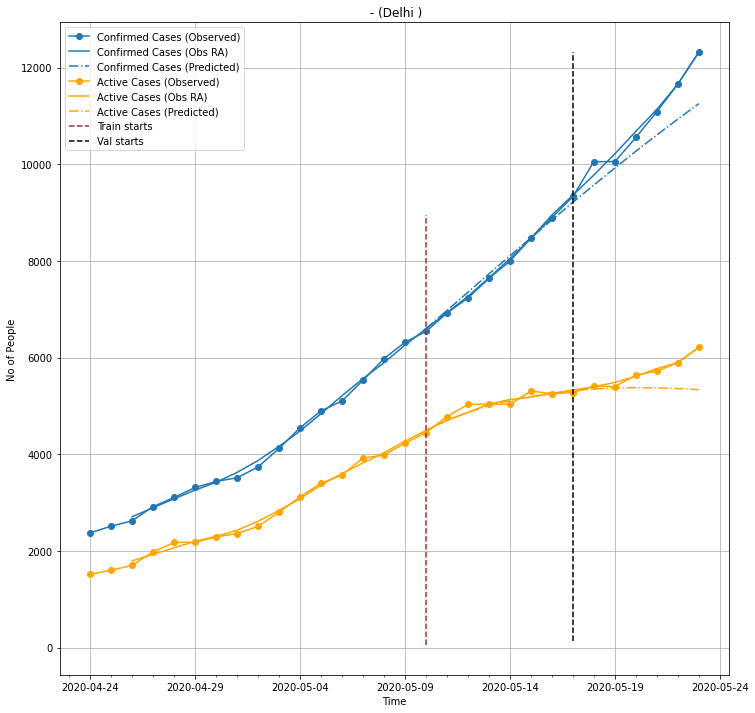

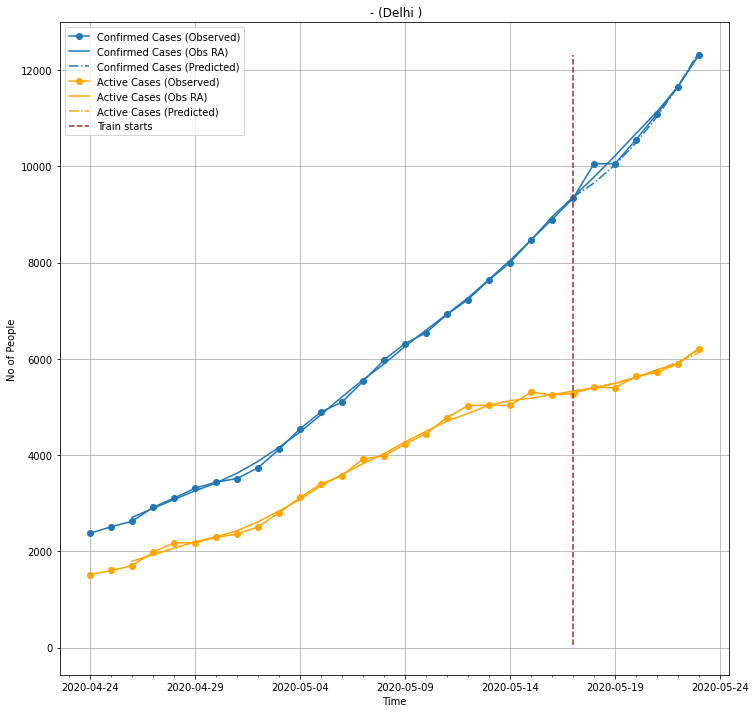

In [8]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=True, initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, 
                                                                     train_on_val=True, data_from_tracker=True, initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected'])

In [72]:
class Optimiser_pymc3(Optimiser):
    def __init__(self):
        super().__init__()
    def solve(self, variable_params, default_params, df_true, start_date=None, end_date=None, 
              state_init_values=None, initialisation='starting', loss_indices=[-20, -10]):
        params_dict = {**variable_params, **default_params}
        if initialisation == 'intermediate':
            row = df_true.iloc[loss_indices[0], :]
            
            state_init_values = OrderedDict()
            key_order = ['S', 'E', 'I', 'D_E', 'D_I', 
                'R_mild', 'R_severe_home', 'R_severe_hosp', 'R_fatal', 'C', 'D']
            for key in key_order:
                state_init_values[key] = 0

            state_init_values['R_severe_hosp'] = params_dict['P_severe'] / (params_dict['P_severe'] + params_dict['P_fatal']) * row['hospitalised']
            state_init_values['R_fatal'] = params_dict['P_fatal'] / (params_dict['P_severe'] + params_dict['P_fatal']) * row['hospitalised']
            state_init_values['C'] = row['recovered']
            state_init_values['D'] = row['deceased']

            state_init_values['E'] = params_dict['E_hosp_ratio'] * row['hospitalised']
            state_init_values['I'] = params_dict['I_hosp_ratio'] * row['hospitalised']
            
            nonSsum = sum(state_init_values.values())
            state_init_values['S'] = (params_dict['N'] - nonSsum)
            for key in state_init_values.keys():
                state_init_values[key] = state_init_values[key]/params_dict['N']
            params_dict['state_init_values'] = state_init_values
        
        if end_date == None:
            end_date = df_true.iloc[-1, :]['date']
        else:
            if type(end_date) is str:
                end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
        
        if start_date != None:
            if type(start_date) is str:
                start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
            params_dict['starting_date'] = start_date


        solver = SEIR_Testing_pymc3(**params_dict)
        total_days = (end_date - params_dict['starting_date']).days
        sol = solver.solve_ode(total_no_of_days=total_days, time_step=1)
        return sol
        #df_prediction = solver.return_predictions(sol)
        #return df_prediction

In [73]:
def get_predictions_mcmc(params, default_params, df_train, initialisation, train_period):
    if train_on_val:
        df_prediction = optimiser.solve(params, default_params, df_train, end_date=df_train.iloc[-1, :]['date'], 
                                        initialisation=initialisation, loss_indices=[-train_period, None])
    else:
        df_prediction = optimiser.solve(params, default_params, df_train, end_date=df_val.iloc[-1, :]['date'],
                                        initialisation=initialisation, loss_indices=[-train_period, None])
    return df_prediction

In [65]:
train_period=7
val_period=0
train_on_val=True
data_from_tracker=True
initialisation='intermediate'
which_compartments=['hospitalised', 'total_infected']
use_mcmc = True
state = "Maharashtra"
district= "Mumbai"
filename=None
pre_lockdown=False
N=1e7

In [51]:
print('fitting to data with "train_on_val" set to {} ..'.format(train_on_val))

if data_from_tracker:
    df_district = get_data(dataframes, state=state, district=district, use_dataframe='districts_daily')
else:
    df_district = get_data(dataframes, state, district, disable_tracker=True, filename=filename)

df_district_raw_data = get_data(dataframes, state=state, district=district, use_dataframe='raw_data')
df_district_raw_data = df_district_raw_data[df_district_raw_data['date'] <= '2020-03-25']

if district is None:
    district = ''

# Get train val split
if pre_lockdown:
    df_train, df_val, df_true_fitting = train_val_split(
        df_district_raw_data, train_rollingmean=False, val_rollingmean=False, val_size=0)
else:
    if train_on_val:
        df_train, df_val, df_true_fitting = train_val_split(
            df_district, train_rollingmean=True, val_rollingmean=True, val_size=0)
        df_train_nora, df_val_nora, df_true_fitting = train_val_split(
            df_district, train_rollingmean=False, val_rollingmean=False, val_size=val_period)
    else:
        df_train, df_val, df_true_fitting = train_val_split(
            df_district, train_rollingmean=True, val_rollingmean=True, val_size=val_period)
        df_train_nora, df_val_nora, df_true_fitting = train_val_split(
            df_district, train_rollingmean=False, val_rollingmean=False, val_size=val_period)

print('train\n', df_train.tail())
print('val\n', df_val)

fitting to data with "train_on_val" set to True ..


/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date hospitalised total_infected deceased  \
24  Maharashtra   Mumbai 2020-05-20        18622        23907.8    829.2   
25  Maharashtra   Mumbai 2020-05-21      19606.8        25404.2    867.6   
26  Maharashtra   Mumbai 2020-05-22      20731.4        27245.6    913.8   
27  Maharashtra   Mumbai 2020-05-23        21772          28817      949   
28  Maharashtra   Mumbai 2020-05-24        22471          30542      988   

   recovered  
24    4456.6  
25    4929.8  
26    5600.4  
27      6096  
28      7083  
val
 None


In [75]:
# Initialise Optimiser
optimiser = Optimiser_pymc3()
# Get the fixed params
if initialisation == 'starting':
    init_infected = max(df_district_raw_data.iloc[0, :]['total_infected'], 1)
    start_date = df_district_raw_data.iloc[0, :]['date']
    default_params = optimiser.init_default_params(df_train, N=N, init_infected=init_infected, 
                                                   start_date=start_date)
if initialisation == 'intermediate':
    start_date = df_train.iloc[-train_period, :]['date']
    default_params = optimiser.init_default_params(df_train, N=N, init_infected=0, 
                                                   start_date=start_date)

In [59]:
#TODO implement which compartments
SEIR_Test_obj = SEIR_Test_pymc3()
num_patients = SEIR_Test_obj.__dict__['vanilla_params']['N']
init_vals = list(SEIR_Test_obj.__dict__['state_init_values'].values())
num_states = 11
num_params = 7
num_steps = 40
num_train_steps = 7

burn_in = 10
mcmc_steps = 20

observed = df_train['total_infected'][-num_train_steps:]
num_train = len(df_train)

In [60]:
sir_model = DifferentialEquation(
    func=SEIR_Test_obj.get_derivative,
    times=np.arange(0, num_steps, 1),
    n_states= num_states,
    n_theta= num_params,
    t0 = 0
)

In [54]:
with pm.Model() as model:
    R0 = pm.Uniform("R0", lower = 1, upper = 3)#(1.6, 3)
    T_inc = pm.Uniform("T_inc", lower = 1, upper = 5)#(3, 4)
    T_inf = pm.Uniform("T_inf", lower = 1, upper = 4)#(3, 4)
    T_recov_severe = pm.Uniform("T_recov_severe ", lower = 9, upper = 20)
    P_severe = pm.Uniform("P_severe", lower = 0.3, upper = 0.99)
    P_fatal = pm.Uniform("P_fatal", lower = 1e-6, upper = 0.3)
    intervention_amount = pm.Uniform("intervention_amount", lower = 0.3, upper = 1)
    E_hosp_ratio = pm.Uniform("E_hosp_ratio", lower = 1e-6, upper = 2)
    I_hosp_ratio = pm.Uniform("I_hosp_ratio", lower = 1e-6, upper = 1)
    
    ode_solution = sir_model(y0=init_vals , theta=[R0, T_inc, T_inf, T_recov_severe, P_severe,
                                                   P_fatal, intervention_amount])
    # The ode_solution has a shape of (n_times, n_states)

    predictions = ode_solution[num_train-num_train_steps-1:num_train-1]
    hospitalised = predictions[:,6] + predictions[:,7] + predictions[:,8]
    recovered = predictions[:,9]
    deceased = predictions[:,10]
    total_infected = hospitalised + recovered + deceased
    total_infected = total_infected * num_patients 
    #sigma = pm.HalfNormal('sigma',
    #                      sigma=observed.std(),
    #                      shape=num_params)
    Y = pm.Normal('Y', mu = total_infected, observed=observed)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(mcmc_steps, tune=burn_in , target_accept=0.9, cores=4)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intervention_amount, P_fatal, P_severe, T_recov_severe , T_inf, T_inc, R0]
Sampling 4 chains, 0 divergences: 100%|██████████| 120/120 [01:13<00:00,  1.63draws/s]
/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The acceptance probability does not match the target. It is 0.7444918184700078, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5100027573170004, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.09490166805994422, but should be close to 0.9. T

In [78]:
trace[0]

{'R0_interval__': -0.5932670477479365,
 'T_inc_interval__': -0.7556645483088107,
 'T_inf_interval__': -0.419023413956952,
 'T_recov_severe _interval__': -0.41940862071480034,
 'P_severe_interval__': 0.058316350693024335,
 'P_fatal_interval__': 0.19110437714962372,
 'intervention_amount_interval__': -0.5873448882961756,
 'R0': 1.7117711869053638,
 'T_inc': 2.2783531155161776,
 'T_inf': 2.19025138659536,
 'T_recov_severe ': 13.3632409772684,
 'P_severe': 0.6550567205841789,
 'P_fatal': 0.1642898187461303,
 'intervention_amount': 0.5500710042916626}

In [76]:
total_df_predictions = pd.DataFrame() 
for params in trace:
    df_prediction = get_predictions_mcmc(params, default_params, df_train, initialisation, train_period)
    total_df_predictions = pd.concat([total_df_prediction, prediction], axis = 1)

KeyError: 'E_hosp_ratio'

In [ ]:
df_prediction = total_df_predictions.mean(axis = 1)
df_upper =  df_prediction  + 1.96*total_df_predictions.std(axis = 1)
df_lower =  df_prediction  - 1.96*total_df_predictions.std(axis = 1)
df_loss = calculate_loss(df_train_nora, df_val_nora, df_prediction, train_period,
                         train_on_val, which_compartments=which_compartments)


ax = create_plots(df_prediction, df_train, df_val, df_train_nora, df_val_nora, train_period, state, district,
                  which_compartments=which_compartments)

results_dict = {}
for name in ['best_params', 'default_params', 'optimiser', 'df_prediction', 'df_district', 'df_train', \
    'df_val', 'df_loss', 'ax']:
    results_dict[name] = eval(name)


## Create Master Loss Dataframe

In [9]:
loss_columns = pd.MultiIndex.from_product([predictions_dict[('Maharashtra', 'Pune')]['m1']['df_loss'].columns, predictions_dict[('Maharashtra', 'Pune')]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                         val  \
                            hospitalised total_infected hospitalised   
Maharashtra Pune                    5.49           1.59         1.92   
            Mumbai                  1.05           3.89         2.26   
Rajasthan   Jaipur                  3.93           0.95        29.52   
Gujarat     Ahmedabad               3.26           1.31        26.28   
Karnataka   Bengaluru Urban         2.89           1.36        10.82   
Delhi       NaN                     1.54           0.92         5.71   

                                            
                            total_infected  
Maharashtra Pune                      7.37  
            Mumbai                    8.74  
Rajasthan   Jaipur                   17.67  
Gujarat     Ahmedabad                29.79  
Karnataka   Bengaluru Urban           9.72  
Delhi       NaN                       4.44

In [14]:
predictions_dict[('Maharashtra','Mumbai')]

{'m1': {'best_params': {'E_hosp_ratio': 0.3778506377511116,
   'I_hosp_ratio': 0.2577089654058299,
   'P_fatal': 0.2860621482136513,
   'P_severe': 0.707715253869647,
   'R0': 2.458413254250211,
   'T_inc': 4.6032169074892355,
   'T_inf': 3.0954140366302307,
   'T_recov_severe': 11.6090628798065,
   'intervention_amount': 0.694595016733021},
  'default_params': {'N': 10000000.0,
   'init_infected': 0,
   'intervention_day': -46,
   'intervention_removal_day': 8,
   'T_hosp': 0.001,
   'starting_date': Timestamp('2020-05-10 00:00:00')},
  'optimiser': <main.seir.optimiser.Optimiser at 0x13e96ea20>,
  'df_prediction':          date        S      E     I  D_E  D_I  R_mild  R_severe_home  \
  0  2020-05-10  9979332   4176  2848    0    0       0              0   
  1  2020-05-11  9977756   4777  2898    0    0       5              0   
  2  2020-05-12  9976125   5312  3036    0    0      10              0   
  3  2020-05-13  9974402   5825  3235    0    0      15              0   
  4  202

## Plot Forecasts

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


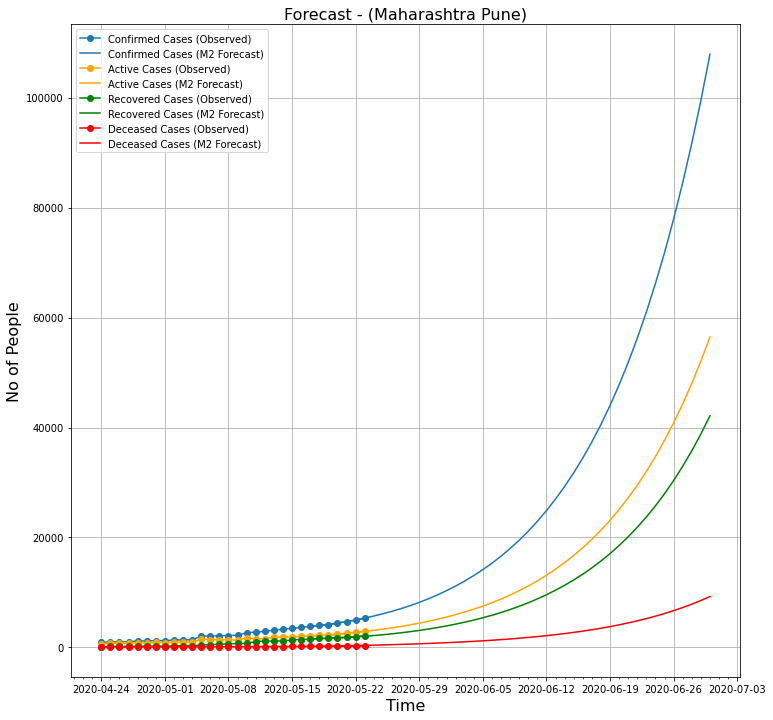

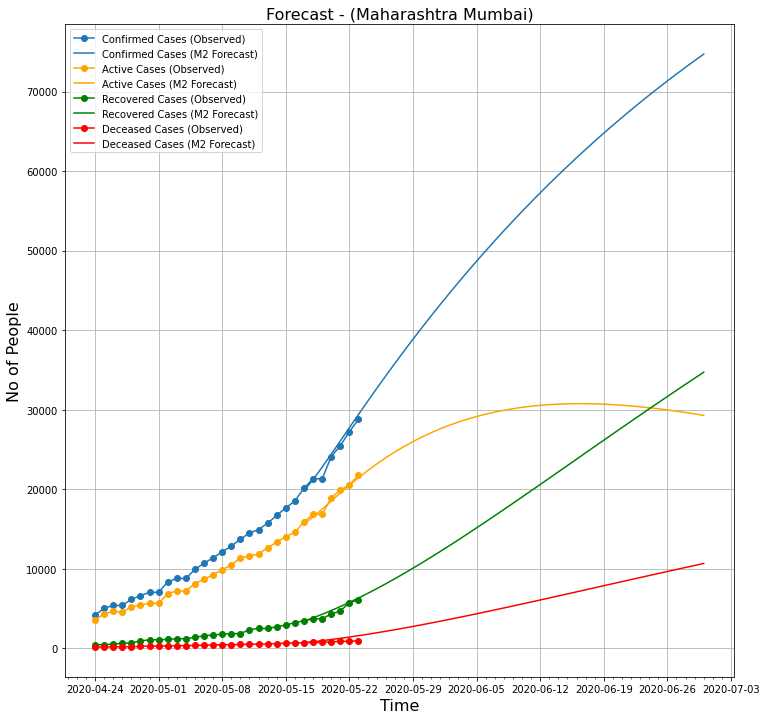

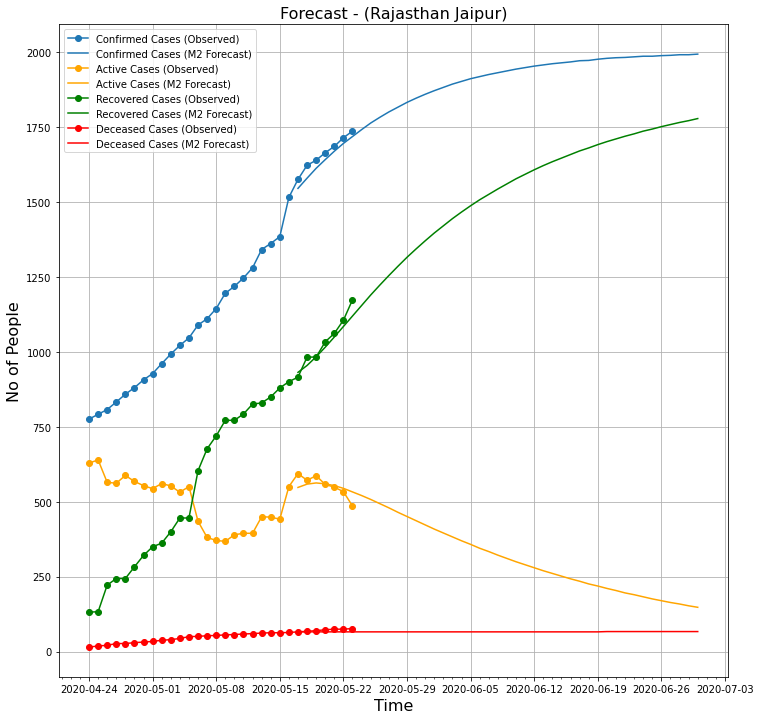

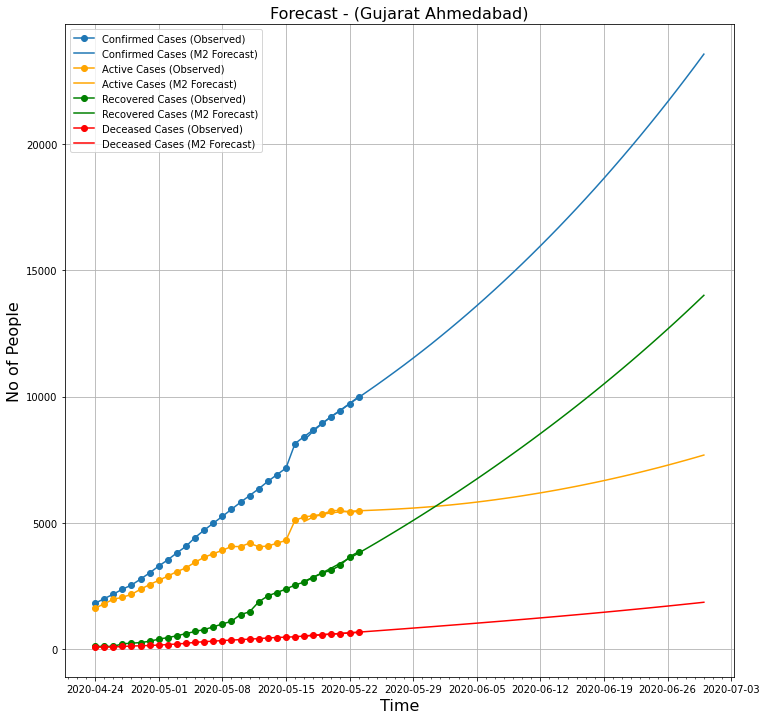

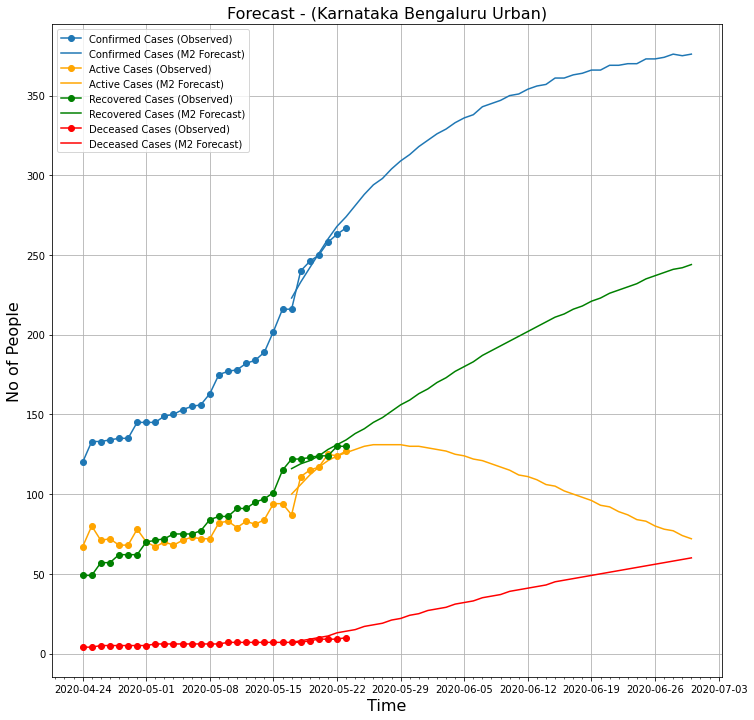

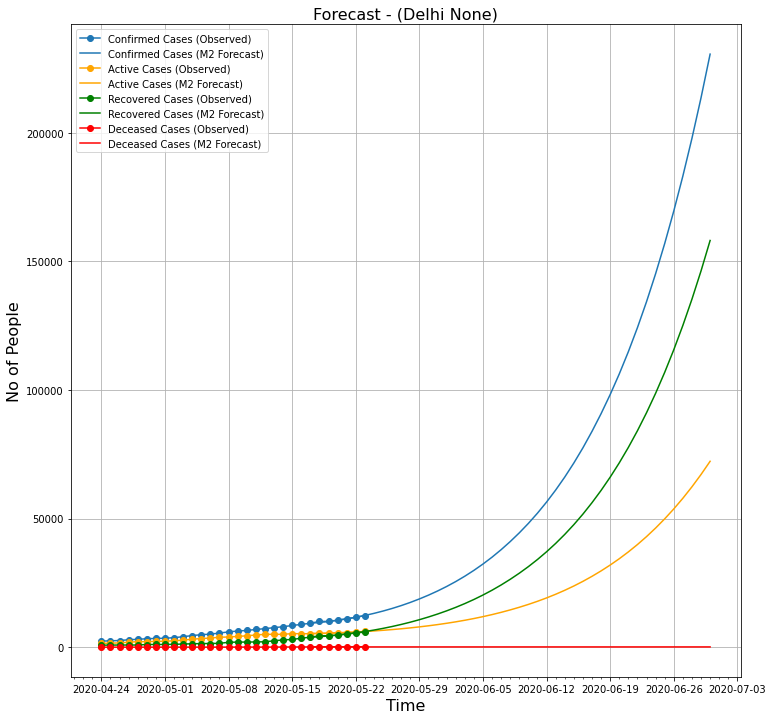

In [12]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False)

## Create and Save Output CSV

In [11]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


KeyError: 'recovered'

In [ ]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

## Custom Pune Plotting

In [ ]:
plot_forecast(predictions_dict[('Maharashtra', 'Pune')], ('Maharashtra', 'Pune'), both_forecasts=False, filename='../../plots/m2-only.eps')

In [ ]:
plot_forecast(predictions_dict[('Maharashtra', 'Mumbai')])